#Morphological Analysis of Time Series Biosignals

On this example we will perform Apnea Detection using AutoEncoders to learn respiration morphology. This notebook will guide you through a morphological approach to analyze biosignals and extract information.



In [0]:
#@title Install important packages
import warnings
warnings.filterwarnings('ignore')
!git clone https://github.com/MarianaAbreu/BioSPPy.git >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install sklearn >/dev/null 2>&1
!pip install pyhrv >/dev/null 2>&1
!pip install tensorflow >/dev/null 2>&1
!pip install keras >/dev/null 2>&1!pip install seaborn >/dev/null 2>&1! pip install pandas_profiling >/dev/null 2>&1

In [0]:
#@title Import libraries
import secrets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pickle


# 2. Data Import

In [0]:
cd BioSPPy

/content/BioSPPy


In [0]:
import biosppy as bs

Using TensorFlow backend.


In [0]:
#@title Import data

user_data = pickle.load(open('examples/data_sep','rb'))
user_labs = pickle.load(open('examples/label_sep','rb'))

train = user_data[0]
test = user_data[1]
y_train = user_labs[0]
y_test = user_labs[1]


# 3. Autoencoder creation and training

Autoencoders are neural networks whom try 
To learn more about autoencoders:
  - [Theoric explanation](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)
  - [More info](https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368)

![alt text ](https://i.ibb.co/F7Hkfzm/ae-scheme.png)

In [0]:
cd biosppy/classification

/content/BioSPPy/biosppy/classification


In [0]:
import utils_classification as uc


label = 'AE1'
loss = 'cosine_proximity'
activ = 'tanh'
opt = 'adam' 
nodes=[500,250,50]

In [0]:
#@title Create and train Autoencoder

from sklearn.model_selection import train_test_split
from importlib import reload  # Python 3.4+ only.
reload(uc)

#Split training set in train and validation 
n_train, n_val, n_ytrain, n_yval = train_test_split(train, y_train, test_size=.4, random_state=42)


from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

#with suppress_stdout():
uc.create_autoencoder(n_train, n_train, n_val, n_val, label, loss, activ, opt, nodes = nodes, epochs=100)


Autoencoder Created:
Layers: [500, 250, 50]
Input Length: 1000
Compression: 50
Activation: tanh
Optimizer: adam
Loss: cosine_proximity

Train on 360 samples, validate on 240 samples
Epoch 1/100
360/360 [==============================] - 1s 1ms/step - loss: -0.1921 - val_loss: -0.4622
Epoch 2/100
360/360 [==============================] - 0s 399us/step - loss: -0.5337 - val_loss: -0.5796
Epoch 3/100
360/360 [==============================] - 0s 406us/step - loss: -0.6312 - val_loss: -0.6344
Epoch 4/100
360/360 [==============================] - 0s 405us/step - loss: -0.6874 - val_loss: -0.6737
Epoch 5/100
360/360 [==============================] - 0s 395us/step - loss: -0.7310 - val_loss: -0.7100
Epoch 6/100
360/360 [==============================] - 0s 418us/step - loss: -0.7677 - val_loss: -0.7406
Epoch 7/100
360/360 [==============================] - 0s 398us/step - loss: -0.7980 - val_loss: -0.7656
Epoch 8/100
360/360 [==============================] - 0s 393us/step - loss: -0.8242

#4. Use Autoencoder

Now that our model is trained, let's use it for reproducing the input signals!


In [0]:
#prediction step:
encoder = pickle.load(open(label + '_encoder', 'rb'))
decoder = pickle.load(open(label + '_decoder', 'rb'))

enc = encoder.predict(test)
dec = decoder.predict(enc)

enc_train = encoder.predict(train)
dec_train = decoder.predict(enc_train)

In [0]:
#choose an index to plot one example between 0 and 599
choose_idx = 230

In [0]:
#@title Plot figure

def label_u(labels, choose_idx = 10):

  if labels[choose_idx] == 'N':
    label_u = 'Normal Respiration'
  if labels[choose_idx] == 'A':
    label_u = 'Apnea'
  return label_u

my_dpi = 100
%matplotlib inline
plt.figure(figsize=(950 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.tight_layout()
plt.plot(dec_train[choose_idx], label='Output')
plt.plot(train[choose_idx], label='Input')
plt.xlabel("time (s)")
plt.ylabel("ADC")
plt.title('Autoencoder Input-Output Comparison - ' + label_u(y_train))
plt.legend()
plt.show()

NameError: ignored

## 4.1 Compute correlation between input and output

In [0]:
correlation_size = 10

In [0]:
#@title Compute correlation between input and output
from scipy.stats import pearsonr
corr_size = correlation_size
train_cl ,test_cl = [] ,[]
y_train_new = []
y_test_new = []

cs = int(1000 /corr_size)
for d in range(len(dec_train)):
    corr_train = [pearsonr(dec_train[d][i: i +cs] ,train[d][i: i +cs])[0] for i in range(0 ,len(dec_train[d]) ,cs)]
    if np.isfinite(corr_train).all():
        train_cl += [corr_train]
        y_train_new += [y_train[d]]

for d in range(len(dec)):

    corr = [pearsonr(dec[d][i: i +cs] ,test[d][i: i +cs])[0] for i in range(0 ,len(dec[d]) ,cs)]

    if np.isfinite(corr).all():
        test_cl += [corr]
        y_test_new += [y_test[d]]


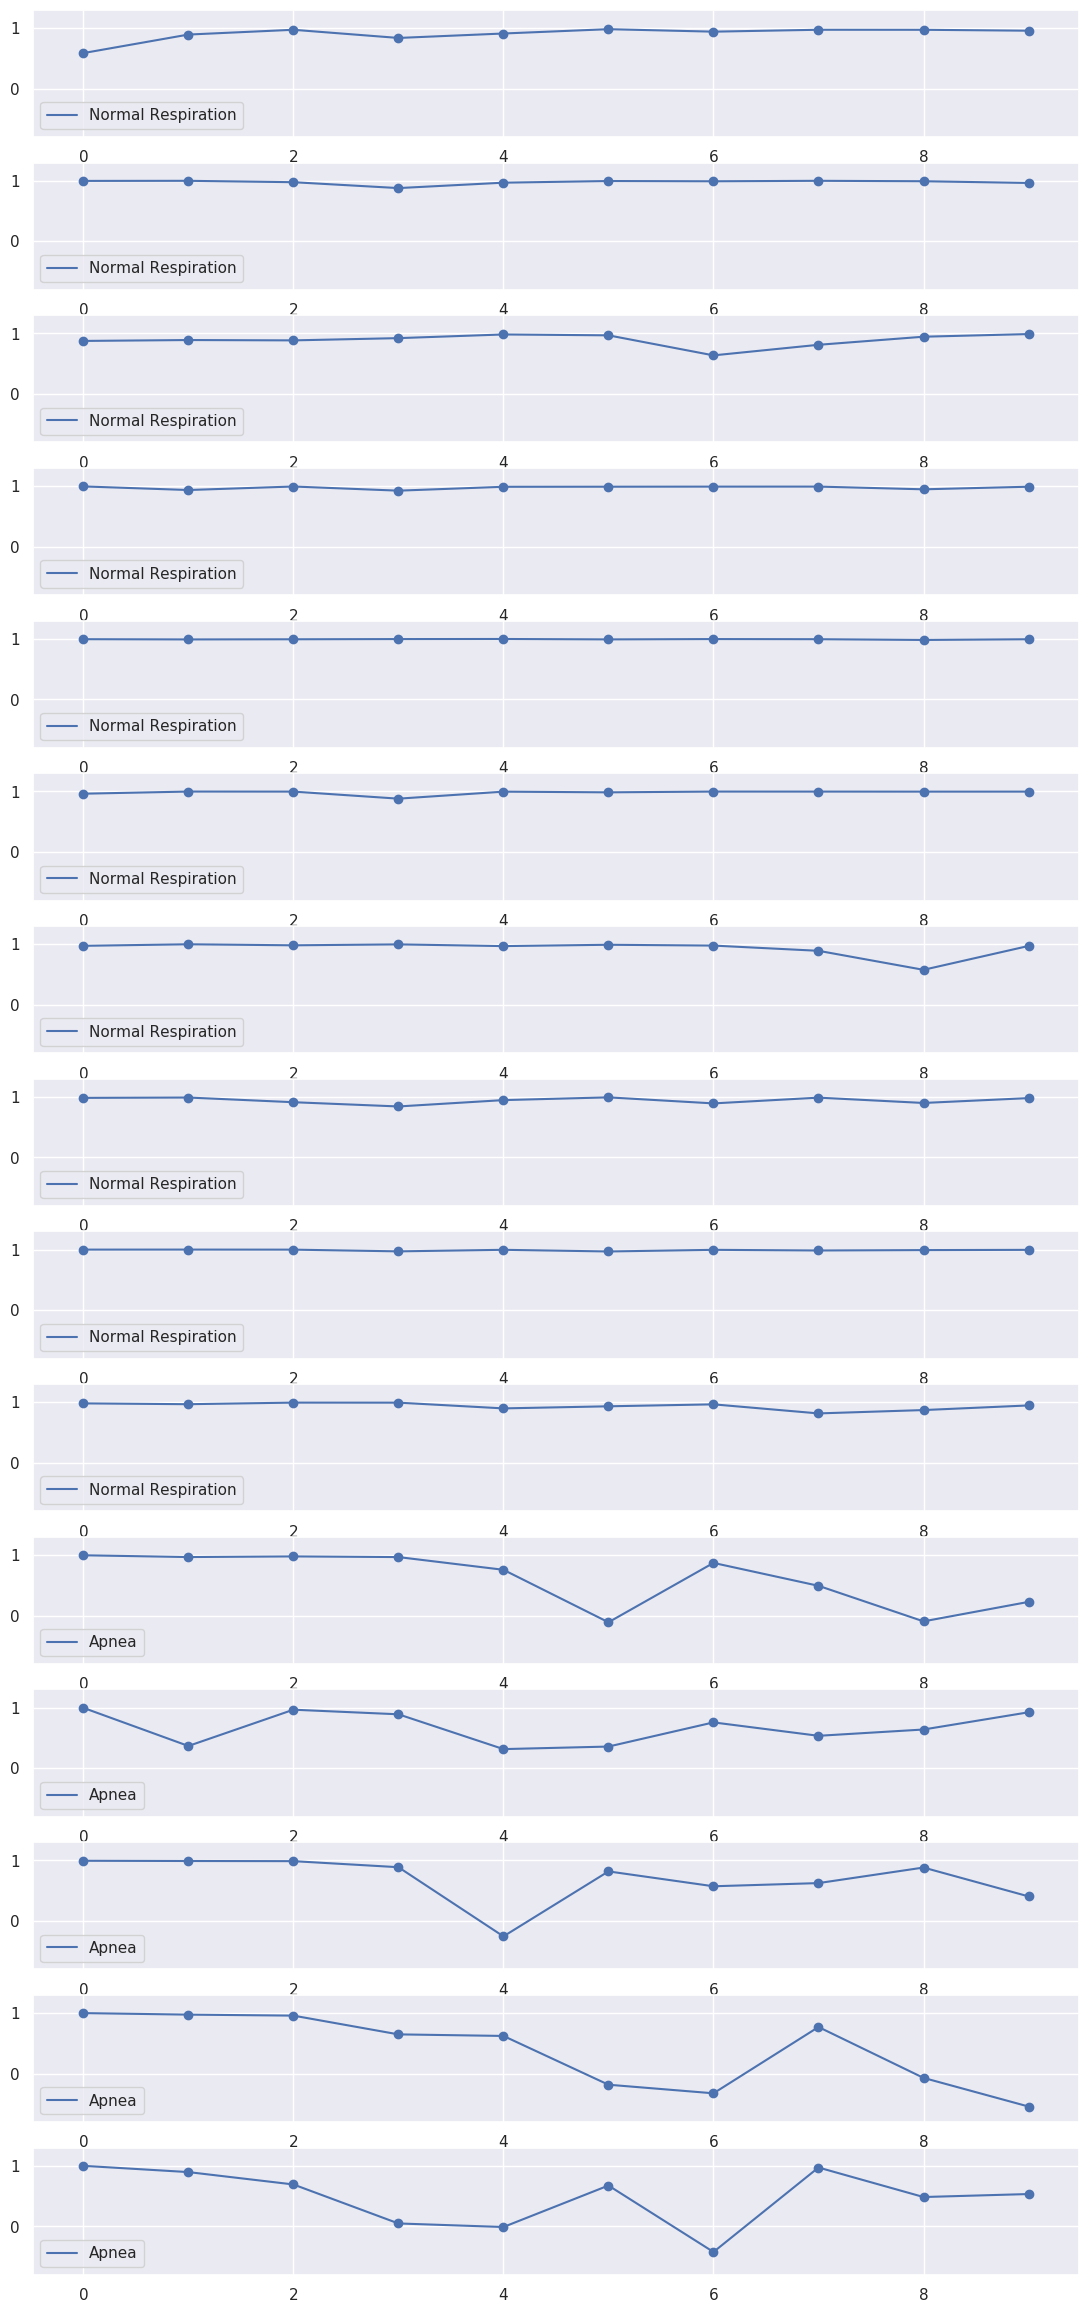

In [0]:
#@title Plot figure

my_dpi = 100


plt.figure(figsize=(1350 / my_dpi, 3000 / my_dpi), dpi=my_dpi)
plt.tight_layout()

for i in range(15):
  choose_idx = i
  plt.subplot(15,1,i+1)
  plt.plot(train_cl[choose_idx],label=label_u(y_train, choose_idx))
  plt.scatter(np.arange(10),train_cl[choose_idx])
  #plt.plot(training_set_x[choose_idx])
  plt.ylim(-0.8,1.3)
  
  plt.legend(loc='lower left')
plt.show()

In [0]:
#@title Supervised learning

from sklearn.metrics import accuracy_score
name = "SVM"
from sklearn.svm import SVC, LinearSVC, NuSVC
classifier = SVC(gamma=2, C=1, probability=True)

def score_classifier_pred(c, n, train, test, y_train, y_test, show=False):
    all_scores = []

    # Train the classifier
    c.fit(train, y_train.ravel())

    # Predict test data
    y_pred = c.predict(test)

    # score = f1_score(y_test, y_pred, average='micro')
    score = accuracy_score(y_test, y_pred)

    # Get the classification accuracy
    print(" --- Final Score: " + str(score) + '%')
    print('-----------------------------------------')
    class_names = np.array(['Apnea', 'Normal'])


    # return [np.round(score*100,2), np.round(accuracy*100,2)]
    return np.round(score * 100, 2), y_pred

_score, pred_label = score_classifier_pred(classifier, name, train_cl,test_cl, np.array(y_train_new), np.array(y_test_new), show=False)

 --- Final Score: 0.8666666666666667%
-----------------------------------------
